# install

In [13]:
!git clone https://github.com/kmrasmussen/pythia_tools.git pythia_tools
!pip install -e pythia_tools
!pip install git+https://github.com/neelnanda-io/TransformerLens.git --quiet

Cloning into 'pythia_tools'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 145 (delta 62), reused 73 (delta 25), pack-reused 34
Receiving objects: 100% (145/145), 57.73 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Obtaining file:///content/pythia_tools
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34

In [1]:
import torch
from pythia_tools.models import get_model, yield_models, get_n_layers, get_tokenizer
from tqdm import tqdm
from pythia_tools.visualization import hist_and_box
from transformer_lens import HookedTransformer
from pythia_tools.data import get_token_mat
import torch.nn.functional as F
from pythia_tools.nonstatic import get_many_hooks_all_layers
import matplotlib.pyplot as plt
from pythia_tools.qh import get_similarity_matrix
from pythia_tools.deembedding import decode_vocab_pmf
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tuned_lens import TunedLens
from transformers import GPTNeoXForCausalLM
import pandas as pd
import itertools
from os.path import join, exists

In [2]:
import torch
device = 'cpu'

In [3]:
chapter_data_path = '/content/drive/MyDrive/thesis/data/chapters/chapter2/'

In [21]:
T322K = torch.load('/content/drive/MyDrive/thesis/data/token_mats/train_322k_600.pt').to(device) #get_token_mat()

In [32]:
T77K = torch.load('/content/drive/MyDrive/thesis/data/token_mats/val_77k_600.pt')

In [6]:
tokenizer = get_tokenizer()

# Unigram statistics

In [7]:
unigram_values, unigram_counts = torch.unique(T_big.reshape(-1), return_counts=True)

In [8]:
unigram_sort = torch.sort(unigram_counts, descending=True)
unigram_sort

torch.return_types.sort(
values=tensor([2148123, 1599418, 1443164,  ...,       1,       1,       1]),
indices=tensor([  173,    13,    11,  ..., 46050,  5207, 21928]))

In [9]:
unigrams_sorted = unigram_values[unigram_sort.indices]

In [10]:
unigrams_counts = unigram_sort.values

In [11]:
unigrams_counts.shape

torch.Size([49864])

In [12]:
unigrams_pmfs = unigrams_counts / unigrams_counts.sum()

Text(0.5, 1.0, 'Frequencies of occurence of unigrams in The Pile')

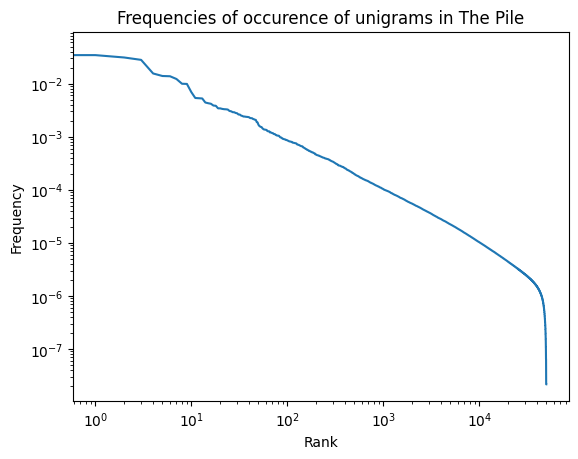

In [13]:
plt.loglog(unigrams_pmfs)
plt.ylabel('Frequency')
plt.xlabel('Rank')
plt.title('Frequencies of occurence of unigrams in The Pile')

In [14]:
unigrams_dict = {
    'sorted_unigrams': unigrams_sorted,
    'counts': unigrams_counts,
    'pmf': unigrams_pmfs
}

In [15]:
#torch.save(unigrams_dict, join(chapter_data_path, 'unigrams_dict_77k.pt'))

In [16]:
for i in range(20):
  print(repr(tokenizer.decode(unigrams_sorted[i])))

'\n'
'.'
','
' the'
' of'
' to'
' and'
' a'
' in'
'-'
' is'
':'
' that'
' for'
' ('
'_'
')'
' on'
' with'
' I'


In [17]:
str([tokenizer.decode(unigrams_sorted[i]) for i in range(20)])

"['\\n', '.', ',', ' the', ' of', ' to', ' and', ' a', ' in', '-', ' is', ':', ' that', ' for', ' (', '_', ')', ' on', ' with', ' I']"

In [18]:
unigrams_dict = torch.load(join(chapter_data_path, 'unigrams_dict_77k.pt'))

In [22]:
unigrams_sorted

tensor([  187,    15,    13,  ..., 46428,  5273, 22120])

In [26]:
tokenizer.encode('text'), tokenizer.encode('button'), tokenizer.encode('submit')

([1156], [8060], [21399])

In [27]:
torch.argwhere(unigrams_sorted == 1156)

tensor([[606]])

In [28]:
torch.argwhere(unigrams_sorted == 8060)

tensor([[2507]])

In [48]:
torch.argwhere(unigrams_sorted == 21399)

tensor([[8743]])

In [45]:
torch.argwhere(unigrams_sorted == 1156)

tensor([[606]])

In [49]:
unigrams_pmfs[606], unigrams_counts[606]

(tensor(0.0002), tensor(7552))

In [51]:
unigrams_pmfs[2507], unigrams_counts[2507]

(tensor(4.4190e-05), tensor(2048))

In [50]:
unigrams_pmfs[8743], unigrams_counts[8743]

(tensor(1.2040e-05), tensor(558))

# Collecting the bigram occurence counts

In [19]:
import torch
from collections import Counter

def count_bigrams(T):
    bigram_counts = Counter()

    # iterate over each sequence separately
    for seq in tqdm(T):
        # Generate bigrams for current sequence
        bigrams = [(seq[i].item(), seq[i + 1].item()) for i in range(len(seq) - 1)]
        # Update the bigram counts
        bigram_counts.update(bigrams)

    # Sort the bigrams by their frequency in descending order
    sorted_bigrams = sorted(bigram_counts.items(), key=lambda item: item[1], reverse=True)

    # Print out the sorted bigrams and their counts
    #for bigram, count in sorted_bigrams:
    #    print(f'Bigram: {bigram}, Count: {count}')
    return sorted_bigrams, bigram_counts

In [20]:
sorted_bigrams, bigram_counts = count_bigrams(T_big)

100%|██████████| 77243/77243 [04:53<00:00, 263.48it/s]


In [29]:
T_big.numel()

46345800

In [33]:
T77K.numel()

46345800

In [30]:
sorted_bigrams_t = torch.stack([torch.tensor(sorted_bigrams[i][0]) for i in tqdm(range(len(sorted_bigrams)))])

100%|██████████| 6859148/6859148 [00:47<00:00, 142956.76it/s]


In [34]:
counts = torch.tensor([count for (bigram, count) in tqdm(sorted_bigrams)])

100%|██████████| 6859148/6859148 [00:02<00:00, 2924198.72it/s]


In [42]:
for i in range(1000):
  print(i, sorted_bigrams_t[i], repr(tokenizer.decode(sorted_bigrams_t[i])), counts[i])

0 tensor([187, 187]) '\n\n' tensor(598192)
1 tensor([ 15, 187]) '.\n' tensor(363071)
2 tensor([273, 253]) ' of the' tensor(173733)
3 tensor([275, 253]) ' in the' tensor(114320)
4 tensor([ 13, 285]) ', and' tensor(105283)
5 tensor([  187, 50274]) '\n    ' tensor(97057)
6 tensor([457,  84]) '’s' tensor(86322)
7 tensor([281, 253]) ' to the' tensor(69934)
8 tensor([ 13, 253]) ', the' tensor(69862)
9 tensor([ 15, 380]) '. The' tensor(66863)
10 tensor([ 27, 187]) ':\n' tensor(59853)
11 tensor([187, 510]) '\nThe' tensor(58313)
12 tensor([  187, 50270]) '\n        ' tensor(56142)
13 tensor([ 28, 187]) ';\n' tensor(50651)
14 tensor([327, 253]) ' on the' tensor(48106)
15 tensor([ 10, 187]) ')\n' tensor(43848)
16 tensor([  187, 50276]) '\n  ' tensor(41967)
17 tensor([ 31, 187]) '>\n' tensor(41014)
18 tensor([323, 253]) ' for the' tensor(40878)
19 tensor([ 13, 533]) ', but' tensor(39448)
20 tensor([285, 253]) ' and the' tensor(39310)
21 tensor([ 32, 187]) '?\n' tensor(38694)
22 tensor([187, 475]) 

In [43]:
counts.sum()

tensor(46268557)

In [35]:
bigram_pmf = counts / counts.sum()

In [44]:
bigram_pmf[655]

tensor(6.8708e-05)

In [36]:
torch.argwhere(counts == 1).min()

tensor(2799449)

Text(0.5, 1.0, 'Frequencies of occurence of bigrams in The Pile')

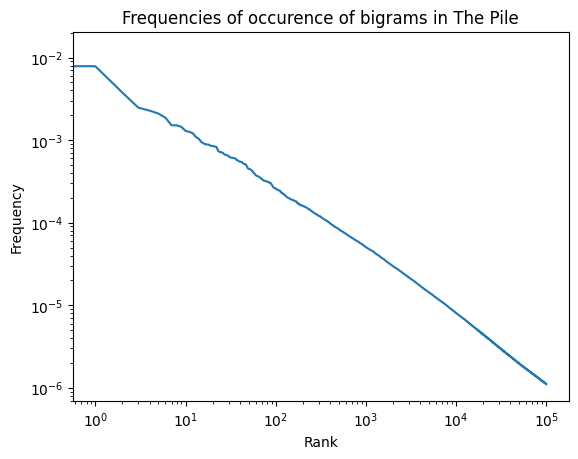

In [ ]:
plt.loglog(bigram_pmf[:100000])
plt.ylabel('Frequency')
plt.xlabel('Rank')
plt.title('Frequencies of occurence of bigrams in The Pile')

In [37]:
str([tokenizer.decode(sorted_bigrams_t[i]) for i in range(20)])

"['\\n\\n', '.\\n', ' of the', ' in the', ', and', '\\n    ', '’s', ' to the', ', the', '. The', ':\\n', '\\nThe', '\\n        ', ';\\n', ' on the', ')\\n', '\\n  ', '>\\n', ' for the', ', but']"

In [ ]:
bigrams_dict = {
    'sorted_bigrams': sorted_bigrams_t,
    'counts': counts,
    'pmf': bigram_pmf
}

In [ ]:
bigrams_dict = torch.load('/content/drive/MyDrive/thesis/data/bigrams/bigrams_dict_77k.pt')

In [ ]:
sorted_bigrams_t = bigrams_dict['sorted_bigrams'].to(device)

In [ ]:
bigram_pmf = bigrams_dict['pmf'].to(device)

# Trigram advantage

In [ ]:
model_70 = get_model('70m', 143, False)

In [ ]:
model_160 = get_model('160m', 143, False)

In [ ]:
model_410 = get_model('410m', 143, False)

In [ ]:
model_1b = get_model('1b', 143, False)

In [ ]:
advantages_bigram_ids = torch.arange(0,10000)

In [ ]:
advantages = torch.zeros(len(advantages_bigram_ids)).to(device)

In [ ]:
len(advantages)

10000

In [ ]:
def get_log_folds(bigram, model):
  unigram = bigram[1:]
  with torch.no_grad():
    ab_out = model(bigram.reshape(1,-1))
  ab_pmf = torch.softmax(ab_out.logits[0,-1],dim=-1)
  with torch.no_grad():
    b_out = model(unigram.reshape(1,-1))
  b_pmf = torch.softmax(b_out.logits[0,-1],dim=-1)
  lfs = torch.log(ab_pmf) - torch.log(b_pmf)
  return lfs

In [ ]:
bigrams = bigrams_dict['sorted_bigrams']

In [ ]:
bigram_id = 100

In [ ]:
bigram = bigrams[bigram_id]

In [ ]:
tokenizer.decode(bigram)

', he'

In [ ]:
lfs_410 = get_log_folds(bigram, model_410)

In [ ]:
lfs_1b = get_log_folds(bigram, model_1b)

In [ ]:
lfs_70 = get_log_folds(bigram, model_70)

In [ ]:
lfs_160 = get_log_folds(bigram, model_160)

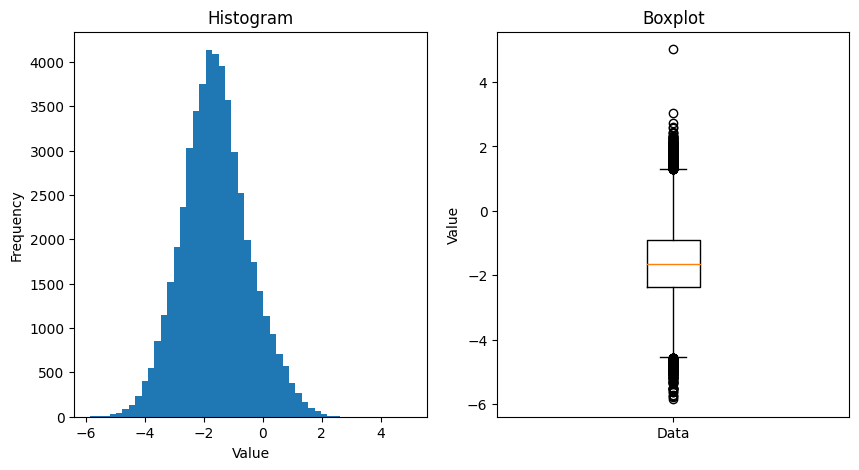

In [ ]:
hist_and_box(lfs_1b)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
lfs_pca = torch.from_numpy(PCA(n_components=1, random_state=1).fit_transform(torch.stack((lfs_160,lfs_410,lfs_1b)).T)).reshape(-1)

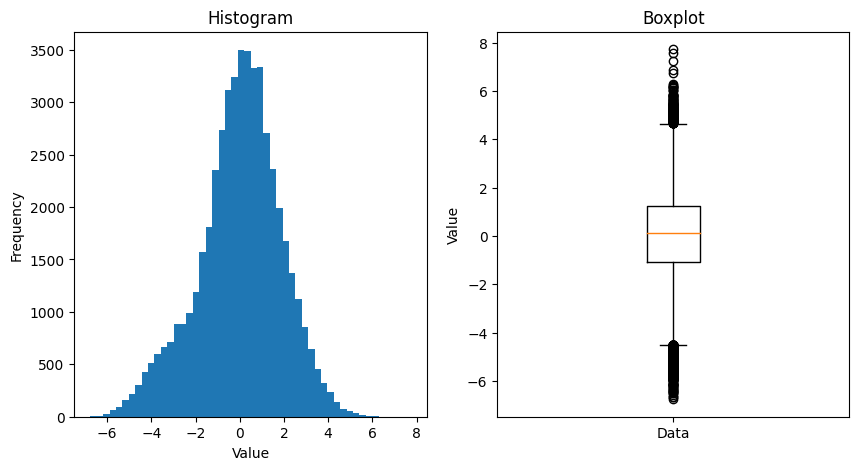

In [ ]:
hist_and_box(lfs_pca)

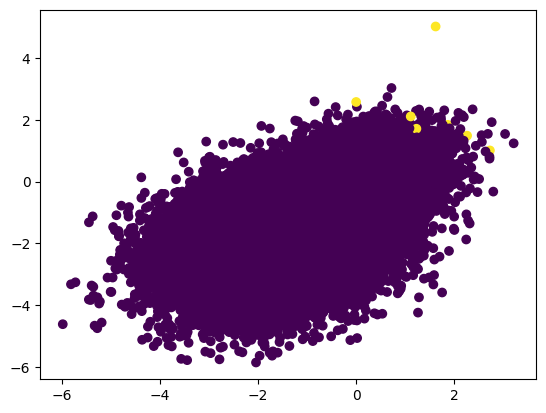

In [ ]:
plt.scatter(lfs_410, lfs_1b, c=lab)

In [ ]:
tokenizer.decode(bigram)

', he'

In [ ]:
for tok in torch.topk(lfs_pca, k=10).indices:
  print(tokenizer.decode((tok)), )

GLE
pire
imester
STITUTE
disambiguation
ίας
MAKE
UIC
ITLE
être


In [ ]:
lab = torch.zeros_like(lfs_pca)

In [ ]:
lab[torch.topk(-lfs_pca, k=10).indices] = 1

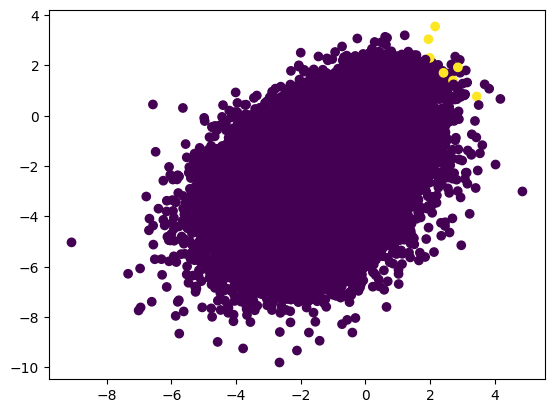

In [ ]:
plt.scatter(lfs_70, lfs_160, c=lab)

In [ ]:
for i, bigram_id in tqdm(enumerate(advantages_bigram_ids)):
  bigram = sorted_bigrams_t[bigram_id]
  unigram = bigram[1:]

  with torch.no_grad():
    ab_out = model(bigram.reshape(1,-1))
  ab_pmf = torch.softmax(ab_out.logits[0,-1],dim=-1)
  with torch.no_grad():
    b_out = model(unigram.reshape(1,-1))
  b_pmf = torch.softmax(b_out.logits[0,-1],dim=-1)

  advantage_summands = ab_pmf * (torch.log(ab_pmf) - torch.log(b_pmf))
  #advantage_summands_list.append(advantage_summands)
  advantage = advantage_summands.sum()
  advantages[i] = advantage

10000it [13:14, 12.59it/s]


Text(0.5, 1.0, 'Unweighted advantage of bigrams')

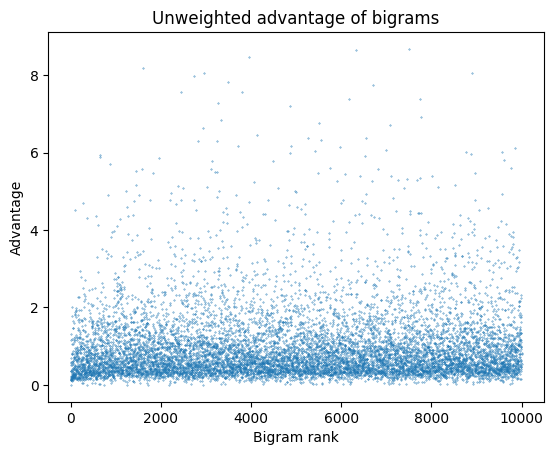

In [ ]:
plt.scatter(advantages_bigram_ids, advantages.cpu(), s=0.1)
plt.xlabel('Bigram rank')
plt.ylabel('Advantage')
plt.title('Unweighted advantage of bigrams')

In [ ]:
advantages_weights = bigram_pmf[advantages_bigram_ids]

In [ ]:
weighted_advantages = advantages_weights * advantages

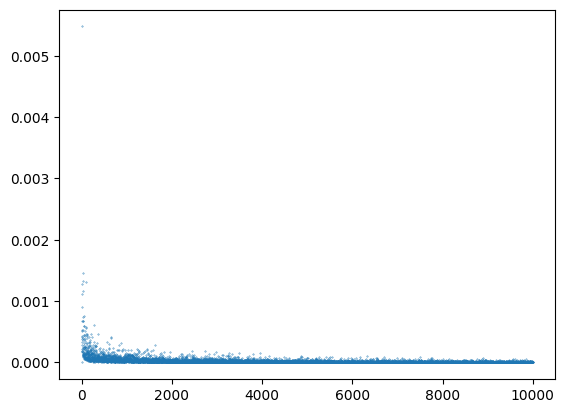

In [ ]:
plt.scatter(advantages_bigram_ids, weighted_advantages.cpu(),s=0.1)

In [ ]:
advantages_dict = {
    'advantages_bigram_ids': advantages_bigram_ids.cpu(),
    'advantages': advantages.cpu(),
    'weighted_advantages': weighted_advantages.cpu()
}

In [ ]:
torch.save(advantages_dict, join(chapter_data_path, 'advantages_dict.pt'))

In [ ]:
wadvantages_sorted = weighted_advantages.sort(descending=True)

In [ ]:
from scipy import stats
import torch

def is_normal(tensor, alpha=0.05):
    """
    Determines if a 1D tensor is normally distributed based on the Shapiro-Wilk test.

    Parameters:
        tensor (torch.Tensor): 1D tensor containing the data
        alpha (float): Significance level for the hypothesis test (default is 0.05)

    Returns:
        bool: True if the tensor is normally distributed, False otherwise
    """
    # Make sure the tensor is 1D
    if len(tensor.shape) != 1:
        raise ValueError("The input tensor must be 1D.")

    # Shapiro-Wilk test
    W, p_value = stats.shapiro(tensor.numpy())

    if p_value > alpha:
        # Fail to reject the null hypothesis, data seems to be normally distributed
        return True
    else:
        # Reject the null hypothesis, data is not normally distributed
        return False


In [ ]:
is_normal(torch.log(weighted_advantages).cpu())

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


True

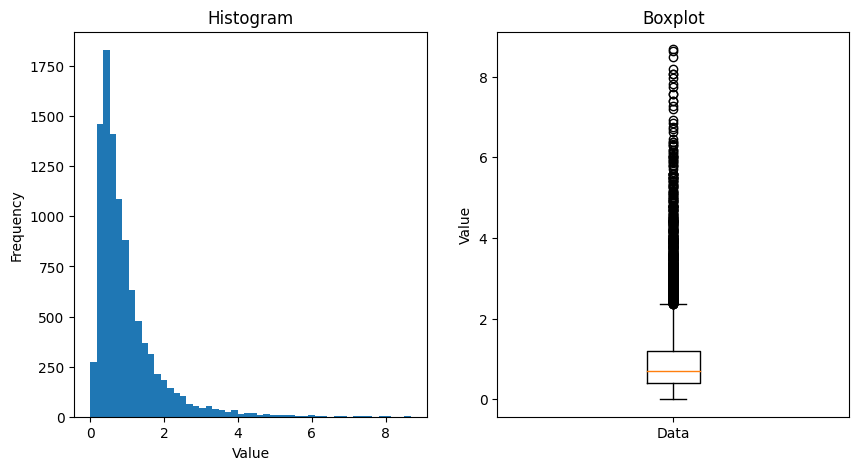

In [ ]:
hist_and_box(advantages)

In [ ]:
for i, (wadvantage, bigram_id) in enumerate(zip(wadvantages_sorted.values, wadvantages_sorted.indices)):
  print(i, bigram_id.item(), repr(tokenizer.decode(sorted_bigrams_t[bigram_id])), round(wadvantage.item(),10))
  if i > 200:
    break

0 1 '.\n' 0.0054784333
1 22 '\n *' 0.0014661548
2 29 ' {\n' 0.0013232718
3 90 ' U.' 0.0013073843
4 13 ';\n' 0.001284253
5 17 '>\n' 0.0011666575
6 6 '’s' 0.0011182475
7 3 ' in the' 0.000896966
8 49 '\n-' 0.0007588118
9 26 '}\n' 0.0007480433
10 21 '?\n' 0.0006779689
11 10 ':\n' 0.0006751787
12 38 '’t' 0.0006744207
13 266 'pone.' 0.000616841
14 57 '.  ' 0.0005973848
15 56 ');\n' 0.0005972899
16 87 '{\n' 0.000572812
17 86 '0.' 0.0005557451
18 30 ' at the' 0.0005329021
19 15 ')\n' 0.0005310453
20 2 ' of the' 0.0005187539
21 78 'S.' 0.0005069618
22 97 '.h' 0.000469907
23 110 '**2' 0.000468109
24 357 ' org.' 0.0004617367
25 211 'include <' 0.0004583396
26 55 '\nA' 0.000448537
27 115 ' 0.' 0.0004466088
28 39 ',\n' 0.0004419317
29 125 'What is' 0.0004300266
30 5 '\n    ' 0.0004274016
31 68 '\n"' 0.0004243874
32 224 'www.' 0.0004184501
33 641 ' java.' 0.0004135513
34 4 ', and' 0.0004113371
35 167 ' I’' 0.0004088762
36 649 'year-' 0.0004063208
37 28 ' is the' 0.0003974624
38 119 'Q:' 0.00039711
3

# Causal advantage

In [ ]:
def load_pkl(path):
  with open(path, 'rb') as file:
    # Load data from the file
    loaded_data = pickle.load(file)
  return loaded_data

In [ ]:
def get_loss(lm_logits, labels, reduction='none'):
  n_seqs = labels.shape[0]
  shift_logits = lm_logits[:, :-1, :].contiguous()
  labels = labels[:, 1:].contiguous()
  loss_fct = torch.nn.CrossEntropyLoss(reduction=reduction)
  lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), labels.view(-1))
  return lm_loss.reshape(n_seqs,-1)

In [ ]:
def get_prev_pred_replacements(out_unabl, abl_pos, n, abl_token):
  pmf_pre = torch.softmax(out_unabl.logits[0,abl_pos-1],dim=0)
  pmf_pre[abl_token] = 0
  pmf = torch.softmax(pmf_pre,dim=0)
  candidates = torch.topk(pmf, k=n).indices #torch.multinomial(torch.softmax(pmf,dim=0),n) #.shape
  return candidates

In [ ]:
def get_occ_importance(seq_id, abl_pos, n_abls=7):
  seq = T[seq_id]
  abl_token = seq[abl_pos]
  #print(abl_pos, abl_token, tokenizer.decode((abl_token)))
  with torch.no_grad():
    out_unabl = model_70(seq.reshape(1,-1), labels=seq.reshape(1,-1))
  abl_tokens = get_prev_pred_replacements(out_unabl,abl_pos,n_abls,abl_token)
  abl_seqs = []
  for abl_token in abl_tokens:
    seq_abl = torch.clone(seq)
    seq_abl[abl_pos] = abl_token
    #print(abl_token, tokenizer.decode((seq[abl_pos])), '->', tokenizer.decode((abl_token)))
    #print(tokenizer.decode(seq_abl[:abl_pos+10]))
    abl_seqs.append(seq_abl)
  abl_seqs_t = torch.stack(abl_seqs)
  with torch.no_grad():
    out_abl = model_70(abl_seqs_t, labels=abl_seqs_t)

  unabl_losses = get_loss(out_unabl.logits, seq.reshape(1,-1))
  abl_losses = get_loss(out_abl.logits, abl_seqs_t)
  delta_losses = abl_losses - unabl_losses
  delta_losses_sum = delta_losses.mean(dim=0)
  remainer, remainer_plus = delta_losses_sum[abl_pos:].sum(), delta_losses_sum[abl_pos+1:].sum()
  return delta_losses, remainer, remainer_plus

In [ ]:
deltas, remainer, remainer_plus = get_occ_importance(0,10, n_abls=7)

In [ ]:
negatives_occsL = load_pkl('/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_occs_precises_2k_bigrams_negatives.pkl')

In [ ]:
tokenizer.decode((T[0,:30]))

"---\nabstract: 'We categorify the notion of an infinitesimal braiding in a linear strict symmetric monoidal category, leading to the notion of"

In [ ]:
import pickle

In [ ]:
precise_occsL = load_pkl('/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_occs_precises_2k_bigrams_considered.pkl')

In [ ]:
def get_abl_deltas(bigram_id):
  current_bigram = tuple(sorted_bigrams_t[bigram_id].tolist())
  delta_losses_meaneds = [] #, []
  for seq_id, pos_id in tqdm(precise_occsL[current_bigram][:1000]):
    if pos_id > 500-1:
      continue
    deltas, remainer, remainer_plus = get_occ_importance(seq_id,pos_id, n_abls=1)
    delta_losses_meaneds.append(deltas.mean(dim=0)[pos_id:pos_id+100])
  deltast = torch.stack(delta_losses_meaneds)
  return deltast

In [ ]:
def cummean(tensor_1d):
    # Compute the cumulative sum
    cumulative_sum = torch.cumsum(tensor_1d, dim=0).cpu()
    # Compute the cumulative mean
    cumulative_mean = cumulative_sum / (torch.arange(len(tensor_1d)) + 1)
    return cumulative_mean

In [ ]:
len(sorted_bigrams_t)

6859148

0





100%|██████████| 1000/1000 [00:42<00:00, 23.49it/s]


10
:



100%|██████████| 1000/1000 [00:41<00:00, 23.95it/s]


20
 and the


100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s]


30
 at the


100%|██████████| 1000/1000 [00:43<00:00, 23.12it/s]


40

	


100%|██████████| 1000/1000 [00:41<00:00, 24.27it/s]


50
, it


100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]


60
 for a


100%|██████████| 1000/1000 [00:42<00:00, 23.81it/s]


70
, in


100%|██████████| 1000/1000 [00:42<00:00, 23.38it/s]


80
 and a


100%|██████████| 1000/1000 [00:42<00:00, 23.69it/s]


90
 U.


100%|██████████| 1000/1000 [00:43<00:00, 22.95it/s]


100
, he


100%|██████████| 1000/1000 [00:42<00:00, 23.69it/s]


110
**2


100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


120
, who


100%|██████████| 1000/1000 [00:41<00:00, 23.91it/s]


130
 to do


100%|██████████| 1000/1000 [00:41<00:00, 24.09it/s]


140
 the most


100%|██████████| 1000/1000 [00:42<00:00, 23.75it/s]


150
. They


100%|██████████| 1000/1000 [00:40<00:00, 24.58it/s]


160
!



100%|██████████| 1000/1000 [00:41<00:00, 23.87it/s]


170
 be a


100%|██████████| 1000/1000 [00:42<00:00, 23.78it/s]


180
http://


100%|██████████| 1000/1000 [00:44<00:00, 22.26it/s]


190
 *



100%|██████████| 1000/1000 [00:48<00:00, 20.52it/s]


200
 able to


100%|██████████| 1000/1000 [00:41<00:00, 24.01it/s]


210
 I was


100%|██████████| 1000/1000 [00:41<00:00, 23.82it/s]


220
 */



100%|██████████| 1000/1000 [00:41<00:00, 24.15it/s]


230
 \[[@B


100%|██████████| 1000/1000 [00:43<00:00, 23.18it/s]


240
 I am


100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]


250
 It is


100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]


260
 and it


100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]


270
 based on


100%|██████████| 1000/1000 [00:42<00:00, 23.67it/s]


280

But


100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]


290
 you are


100%|██████████| 1000/1000 [00:40<00:00, 24.63it/s]


300

As


100%|██████████| 1000/1000 [00:41<00:00, 24.00it/s]


310
, where


100%|██████████| 1000/1000 [00:42<00:00, 23.50it/s]


320
 according to


100%|██████████| 1000/1000 [00:42<00:00, 23.26it/s]


330
 are the


100%|██████████| 1000/1000 [00:42<00:00, 23.60it/s]


340
": "


100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s]


350
 some of


100%|██████████| 1000/1000 [00:42<00:00, 23.27it/s]


360
. When


100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]


370
 but it


100%|██████████| 1000/1000 [00:41<00:00, 24.27it/s]


380
 that they


100%|██████████| 1000/1000 [00:39<00:00, 25.03it/s]


390
 the end


100%|██████████| 1000/1000 [00:42<00:00, 23.77it/s]


400
I have


100%|██████████| 1000/1000 [00:46<00:00, 21.62it/s]


410
 but the


100%|██████████| 1000/1000 [00:40<00:00, 24.59it/s]


420
 do not


100%|██████████| 1000/1000 [00:40<00:00, 24.72it/s]


430
1)


100%|██████████| 1000/1000 [00:41<00:00, 23.98it/s]


440
4.


100%|██████████| 1000/1000 [00:42<00:00, 23.69it/s]


450
. These


100%|██████████| 1000/1000 [00:43<00:00, 23.24it/s]


460

He


100%|██████████| 1000/1000 [00:43<00:00, 23.06it/s]


470
- '


100%|██████████| 1000/1000 [00:48<00:00, 20.82it/s]


480
, at


100%|██████████| 1000/1000 [00:41<00:00, 23.85it/s]


490
(a


100%|██████████| 1000/1000 [00:42<00:00, 23.65it/s]


500
, however


100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s]


510
, not


100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]


520
3



100%|██████████| 1000/1000 [00:42<00:00, 23.58it/s]


530
 known as


100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


540
 years,


100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]


550


	


100%|██████████| 1000/1000 [00:39<00:00, 25.27it/s]


560
 like to


100%|██████████| 1000/1000 [00:43<00:00, 22.91it/s]


570
 I've


100%|██████████| 1000/1000 [00:44<00:00, 22.71it/s]


580
2*


100%|██████████| 1000/1000 [00:41<00:00, 23.81it/s]


590
 S.


100%|██████████| 1000/1000 [00:42<00:00, 23.42it/s]


600
.ref


100%|██████████| 1000/1000 [00:41<00:00, 23.89it/s]


610

the


100%|██████████| 1000/1000 [00:40<00:00, 24.42it/s]


620
 before the


100%|██████████| 1000/1000 [00:41<00:00, 24.36it/s]


630
 said,


100%|██████████| 1000/1000 [00:40<00:00, 24.87it/s]


640
 to this


100%|██████████| 1000/1000 [00:41<00:00, 23.82it/s]


650
 along with


100%|██████████| 1000/1000 [00:42<00:00, 23.28it/s]


660
 like a


100%|██████████| 1000/1000 [00:42<00:00, 23.28it/s]


670
 - 2


100%|██████████| 1000/1000 [00:41<00:00, 24.06it/s]


680

4


100%|██████████| 1000/1000 [00:39<00:00, 25.12it/s]


690
 associated with


100%|██████████| 1000/1000 [00:43<00:00, 22.76it/s]


700

L


100%|██████████| 1000/1000 [00:41<00:00, 23.82it/s]


710

F


100%|██████████| 1000/1000 [00:42<00:00, 23.36it/s]


720
 this year


100%|██████████| 1000/1000 [00:43<00:00, 23.05it/s]


730
 that was


100%|██████████| 1000/1000 [00:42<00:00, 23.59it/s]


740
, even


100%|██████████| 1000/1000 [00:40<00:00, 24.95it/s]


750
 for example


100%|██████████| 1000/1000 [00:42<00:00, 23.70it/s]


760
 and they


100%|██████████| 1000/1000 [00:42<00:00, 23.81it/s]


770
-8


100%|██████████| 1000/1000 [00:44<00:00, 22.59it/s]


780
’d


100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s]


790
 time to


100%|██████████| 1000/1000 [00:42<00:00, 23.74it/s]


800
 use the


100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


810
 co-


100%|██████████| 1000/1000 [00:41<00:00, 23.82it/s]


820
 that’


100%|██████████| 1000/1000 [00:41<00:00, 23.89it/s]


830
.set


100%|██████████| 1000/1000 [00:37<00:00, 26.66it/s]


840
 to



100%|██████████| 1000/1000 [00:40<00:00, 24.55it/s]


850
.00


100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s]


860
 on this


100%|██████████| 1000/1000 [00:41<00:00, 24.25it/s]


870
 try to


100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s]


880
 You can


100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]


890
 copy of


100%|██████████| 1000/1000 [00:47<00:00, 20.85it/s]


900
 on an


100%|██████████| 1000/1000 [00:45<00:00, 21.81it/s]


910
-01


100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s]


920
 to their


100%|██████████| 1000/1000 [00:41<00:00, 24.05it/s]


930
 up with


100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]


940
(0


100%|██████████| 1000/1000 [00:39<00:00, 25.02it/s]


950
; and


100%|██████████| 1000/1000 [00:40<00:00, 24.75it/s]


960
 for his


100%|██████████| 1000/1000 [00:42<00:00, 23.78it/s]


970
 not only


100%|██████████| 1000/1000 [00:42<00:00, 23.53it/s]


980
g.


100%|██████████| 1000/1000 [00:42<00:00, 23.60it/s]


990
 on your


100%|██████████| 1000/1000 [00:41<00:00, 23.98it/s]


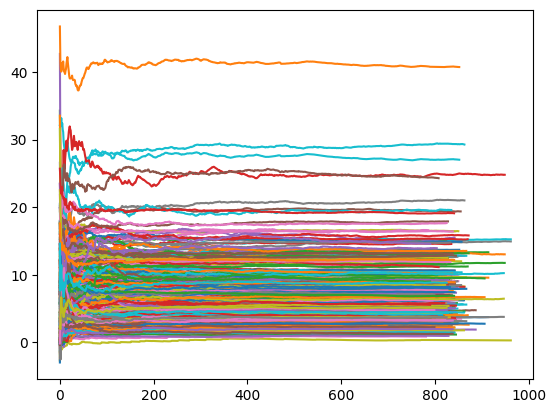

In [ ]:
deltast_list = []
for bigram_id in range(0,1000,10):
  print(bigram_id)
  print(tokenizer.decode(sorted_bigrams_t[bigram_id]))
  deltast = get_abl_deltas(bigram_id)
  deltast_list.append(deltast)
  plt.plot(cummean(deltast[:,1:].sum(dim=-1)))
  plt.plot(cummean(deltast[:,:1].sum(dim=-1)))
  plt.plot(cummean(deltast[:,:].sum(dim=-1)))

In [ ]:
deltast = deltast_list[0]

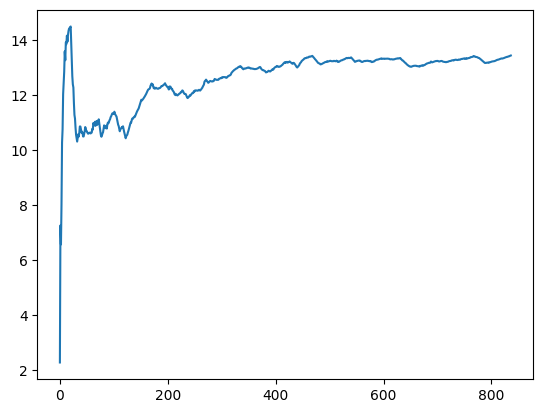

In [ ]:
plt.plot(cummean(deltast[:,:].sum(dim=-1)))

In [ ]:
cadvs = torch.stack([deltast.sum(dim=-1).mean() for deltast in deltast_list])

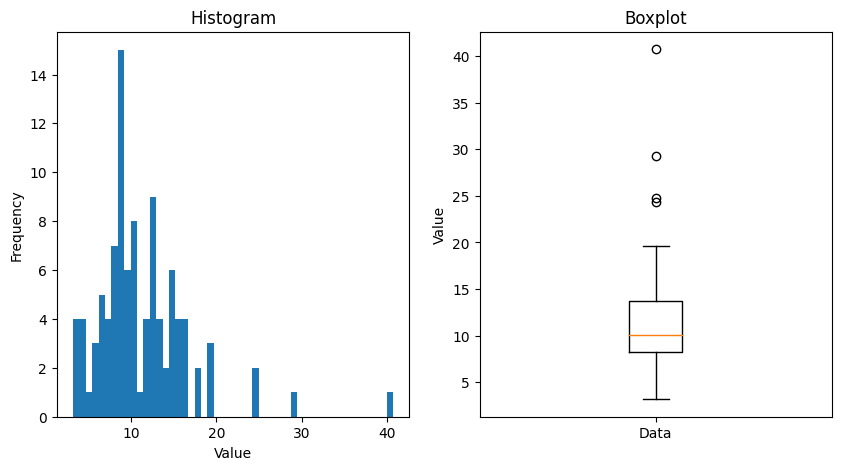

In [ ]:
hist_and_box(cadvs)

In [ ]:
deltas_mean = torch.stack([elem.sum(dim=0).cpu() for elem in deltast_list])

In [ ]:
causal_adv = deltas_mean.mean(dim=-1)

In [ ]:
torch.topk(causal_adv, k=10)

torch.return_types.topk(
values=tensor([347.5316, 253.0029, 235.6479, 196.5842, 165.9458, 163.8177, 160.9296,
        148.4773, 146.8849, 145.8811]),
indices=tensor([23,  9, 47, 61, 11, 49, 97, 81, 19, 88]))

In [ ]:
for bigram_id in torch.topk(-cadvs, k=10).indices * 10:
  print(repr(tokenizer.decode(sorted_bigrams_t[bigram_id])))

'\n\n\t'
'g.'
'3\n'
'2*'
'!\n'
' but it'
' but the'
' years,'
'4.'
'1)'


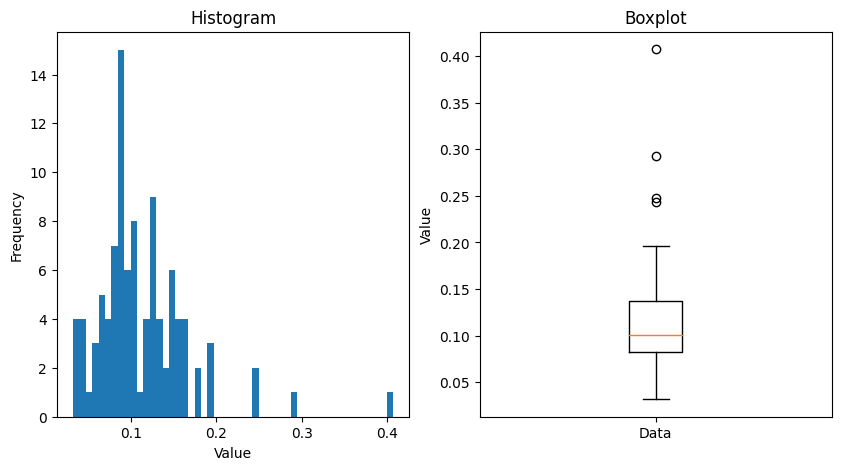

In [ ]:
hist_and_box(causal_adv)

In [ ]:
torch.topk()

In [ ]:
deltas_list_cpu = [elem.cpu() for elem in deltast_list]

In [ ]:
deltas_dict = {
    'model': '70m',
    'sorted_bigrams_t': sorted_bigrams_t,
    'bigram_indices': torch.arange(0,1000,10),
    'deltas_list': deltas_list_cpu,
}

In [ ]:
torch.save(deltas_dict, '/content/drive/MyDrive/thesis/data/chapters/chapter2/causal_advantages_100_stride10.pt')

In [ ]:
deltast = torch.stack(delta_losses_meaneds)

In [ ]:
deltast2.shape

torch.Size([832, 100])

In [ ]:
deltast2 = get_abl_deltas(1000)

100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s]


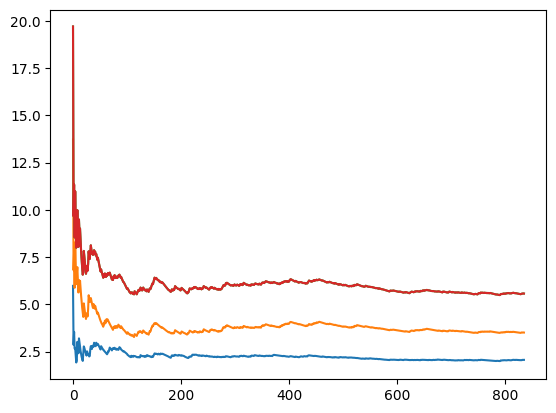

In [ ]:
plt.plot(cummean(deltast2[:,1:].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:1].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:1].sum(dim=-1)) + cummean(deltast2[:,1:].sum(dim=-1)))

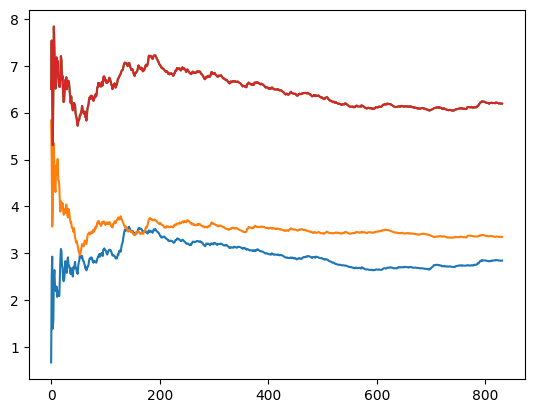

In [ ]:
plt.plot(cummean(deltast2[:,1:].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:1].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:].sum(dim=-1)))
plt.plot(cummean(deltast2[:,:1].sum(dim=-1)) + cummean(deltast2[:,1:].sum(dim=-1)))

In [ ]:
deltast.shape

torch.Size([832, 100])

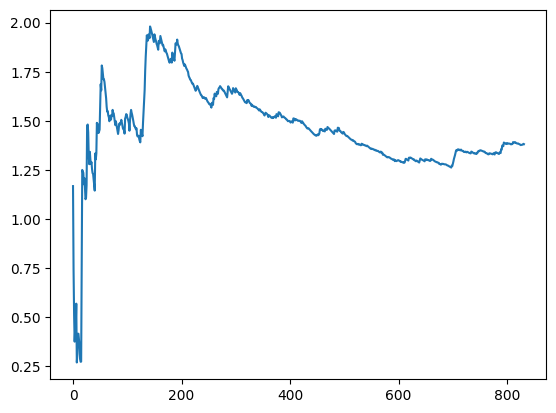

In [ ]:
plt.plot(cummean(deltast2[:,1]))

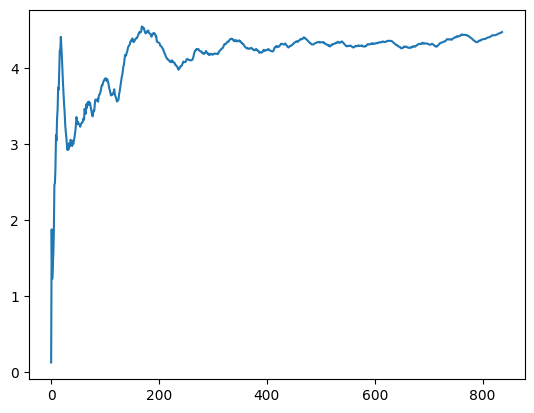

In [ ]:
plt.plot(cummean(deltast2[:,1]))

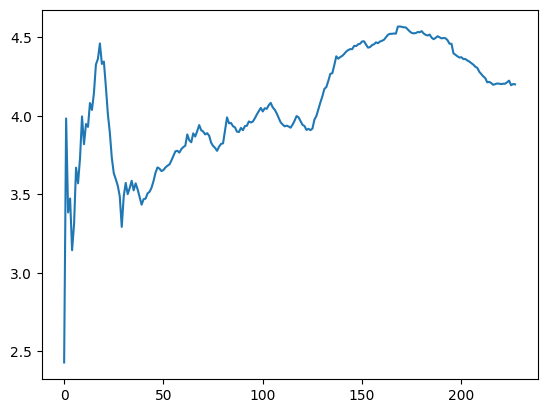

In [ ]:
plt.plot(cummean(deltast2[:,1]))

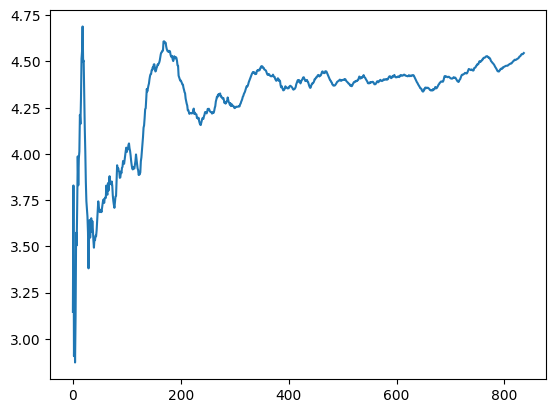

In [ ]:
plt.plot(cummean(deltast[:,1]))

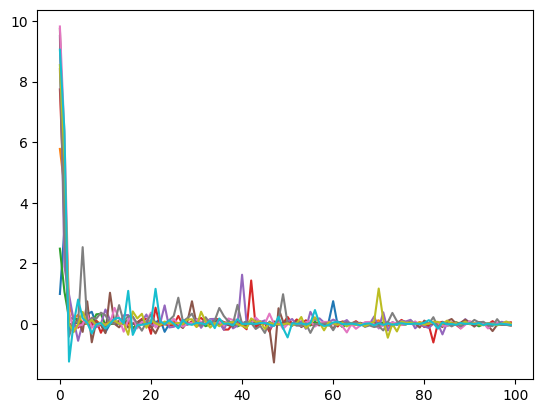

In [ ]:
for deltas_curve in deltast:
  plt.plot(deltas_curve)

In [ ]:
deltast[:,1]

tensor([3.1459, 4.5127, 1.0593, 3.7577, 1.8822, 4.3960, 6.2609, 3.0257, 5.4573,
        6.3681])

In [ ]:
remainer

tensor(37.7602)

In [ ]:
precise_occsL[(187, 187)]

[(0, 395),
 (0, 455),
 (0, 465),
 (1, 37),
 (1, 79),
 (1, 237),
 (1, 285),
 (1, 453),
 (2, 98),
 (2, 168),
 (2, 173),
 (2, 216),
 (2, 250),
 (2, 282),
 (2, 290),
 (2, 342),
 (2, 416),
 (2, 424),
 (2, 468),
 (2, 528),
 (3, 182),
 (3, 353),
 (3, 540),
 (4, 69),
 (4, 80),
 (4, 130),
 (4, 151),
 (4, 163),
 (4, 246),
 (4, 435),
 (4, 465),
 (6, 54),
 (6, 282),
 (6, 363),
 (6, 367),
 (7, 33),
 (7, 75),
 (7, 84),
 (7, 161),
 (7, 198),
 (7, 203),
 (7, 208),
 (7, 214),
 (7, 220),
 (7, 226),
 (7, 232),
 (7, 238),
 (7, 259),
 (7, 296),
 (7, 388),
 (7, 401),
 (7, 406),
 (7, 412),
 (7, 417),
 (7, 422),
 (7, 428),
 (7, 433),
 (7, 438),
 (7, 447),
 (7, 453),
 (7, 458),
 (7, 468),
 (7, 492),
 (7, 497),
 (7, 502),
 (7, 508),
 (7, 514),
 (7, 520),
 (7, 526),
 (7, 532),
 (8, 81),
 (8, 240),
 (8, 337),
 (8, 352),
 (8, 355),
 (9, 86),
 (9, 139),
 (9, 142),
 (9, 311),
 (9, 394),
 (9, 457),
 (10, 102),
 (10, 145),
 (10, 235),
 (10, 337),
 (11, 187),
 (11, 569),
 (13, 186),
 (13, 198),
 (13, 495),
 (13, 509),


In [ ]:
tok_i = 273
negative_i = 0
negatives_occsL[tok_i][negative_i][0]

(0, 28)

In [ ]:
T[0,28+1]

tensor(273)

In [ ]:
tokenizer.decode((T[0,12]))

' Spain'

In [ ]:
deltas.mean(dim=0)[12]

tensor(1.2329)

In [ ]:
deltas.sum(dim=0)[10-1:].sum()

tensor(140.1735)

In [ ]:
deltas.sum(dim=0)[10:].sum()

tensor(166.2761)

In [ ]:
deltas.sum(dim=0)[10]

tensor(75.1559)

In [ ]:
remainer, remainer_plus

(tensor(166.2761), tensor(91.1202))

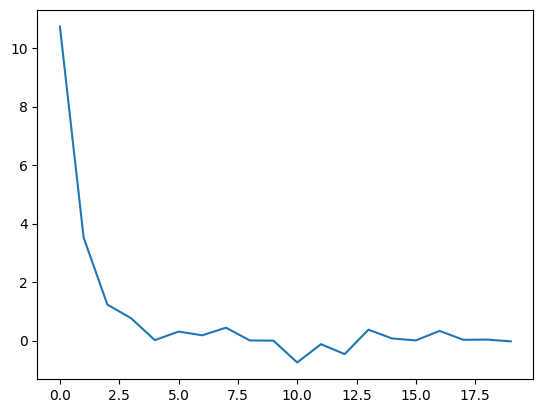

In [ ]:
plt.plot(deltas[:,10:].mean(dim=0)[:20])

In [ ]:
deltas.sum()

tensor(185.2345)

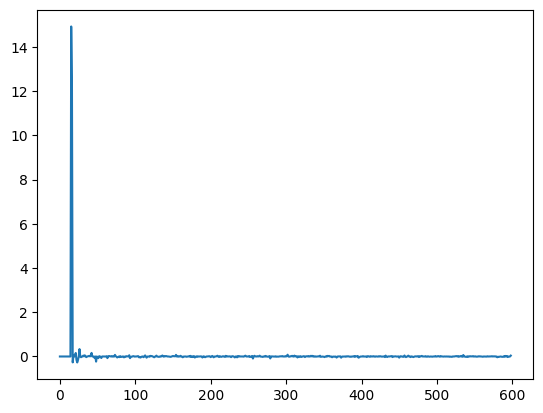

In [ ]:
plt.plot(deltas.mean(dim=0))

In [ ]:
tokenizer.decode(seq)

'Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests\n\nimage copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont\n\nCatalonia\'s ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.\n\nHe said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.\n\nSpain\'s Prime Minister Mariano Rajoy later appeared to reject the idea.\n\nHe said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.\n\nHe avoided naming Mr Puigdemont, adding that the winner of Thursday\'s election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.\n\nThe Citizens party is now the region\'s biggest party. although p

In [ ]:
with torch.no_grad():
  out_unabl = model_70(seq.reshape(1,-1), labels=seq.reshape(1,-1))

In [ ]:
def get_unigram_replacements(n):
  n_unigram_samples = n
  unigram_samples = unigrams_dict['sorted_unigrams'][torch.multinomial(unigrams_dict['pmf'], n_unigram_samples)]
  return unigram_samples

In [ ]:
seq = T[0]

In [ ]:
n_abls = 7

In [ ]:
unigram_samples = get_unigram_replacements(n_abls)

In [ ]:
unigram_samples

tensor([  187, 50274,    14,    15,  4496,  2552,  1500])

In [ ]:
abl_pos = 10

In [ ]:
abl_token = seq[abl_pos]
print(abl_token, tokenizer.decode((abl_token)))

tensor(12088)  talks


In [ ]:
prev_samples = get_prev_pred_replacements(out_unabl,abl_pos,n_abls,abl_token)

In [ ]:
abl_tokens = unigram_samples #prev_samples

In [ ]:
abl_seqs = []
for abl_token in abl_tokens:
  seq_abl = torch.clone(seq)
  seq_abl[abl_pos] = abl_token
  print(abl_token, tokenizer.decode((seq[abl_pos])), '->', tokenizer.decode((abl_token)))
  print(tokenizer.decode(seq_abl[:abl_pos+10]))
  abl_seqs.append(seq_abl)
abl_seqs_t = torch.stack(abl_seqs) #.unsqueeze(0)

tensor(187)  talks -> 

Catalonia election: Puigdemont calls for
 with Spain Published duration 22 December 2017 Related Top
tensor(50274)  talks ->     
Catalonia election: Puigdemont calls for     with Spain Published duration 22 December 2017 Related Top
tensor(14)  talks -> -
Catalonia election: Puigdemont calls for- with Spain Published duration 22 December 2017 Related Top
tensor(15)  talks -> .
Catalonia election: Puigdemont calls for. with Spain Published duration 22 December 2017 Related Top
tensor(4496)  talks ->  please
Catalonia election: Puigdemont calls for please with Spain Published duration 22 December 2017 Related Top
tensor(2552)  talks ->  May
Catalonia election: Puigdemont calls for May with Spain Published duration 22 December 2017 Related Top
tensor(1500)  talks ->  She
Catalonia election: Puigdemont calls for She with Spain Published duration 22 December 2017 Related Top


In [ ]:
with torch.no_grad():
  out_abl = model_70(abl_seqs_t, labels=abl_seqs_t)

In [ ]:
unabl_losses = get_loss(out_unabl.logits, seq.reshape(1,-1))
abl_losses = get_loss(out_abl.logits, abl_seqs_t)

In [ ]:
abl_losses.shape

torch.Size([7, 599])

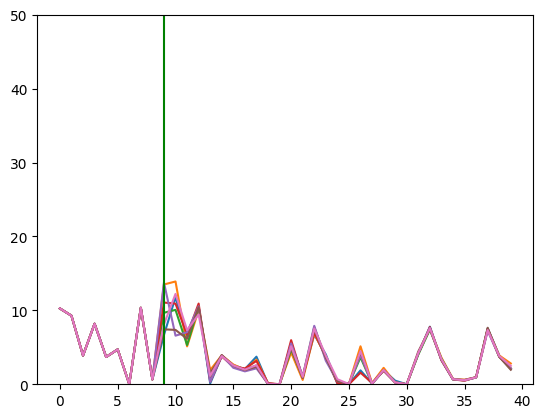

In [ ]:
for abl_losses_elem in abl_losses:
  plt.plot(abl_losses_elem[:abl_pos+30])
plt.axvline(x=abl_pos-1,color='green',label='ablation position')
#plt.ylim((0,50))
#plt.show()
#plt.plot(abl_losses[1][:abl_pos+30])
#plt.axvline(x=abl_pos-1,color='green',label='ablation position')
plt.ylim((0,50))
plt.show()

In [ ]:
tokenizer.decode((seq[38]))

' dialogue'

In [ ]:
abl_losses.shape

torch.Size([7, 599])

In [ ]:
unabl_losses.shape

torch.Size([1, 599])

In [ ]:
delta_losses = abl_losses - unabl_losses

In [ ]:
delta_losses.sum(dim=-1)

tensor([17.4824, 31.5721, 19.0849, 21.0847, 22.5518, 18.4747, 26.4118])

In [ ]:
delta_losses.sum(dim=-1)

tensor([30.6664, 25.7553, 20.7588, 26.0833, 22.5555, 24.8327, 21.0847])

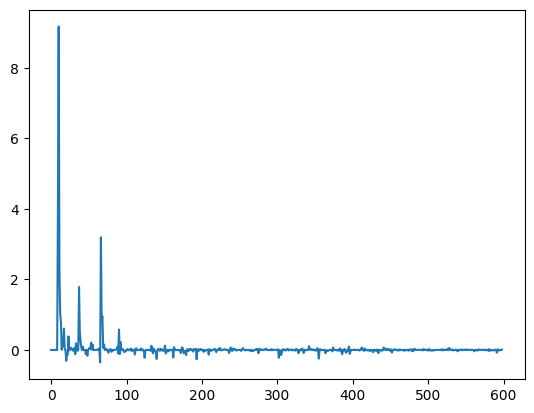

In [ ]:
plt.plot(delta_losses.mean(dim=0))

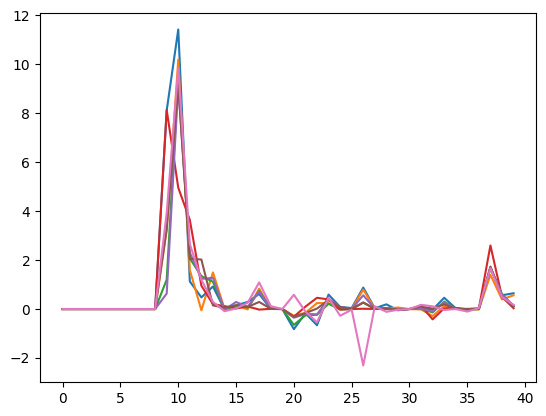

In [ ]:
for delta_losses_elem in delta_losses:
  plt.plot(delta_losses_elem[:abl_pos+30])

In [ ]:
deltas_losses = abl_losses - unabl_losses

RuntimeError: ignored

Text(0.5, 0, 'Sequence position')

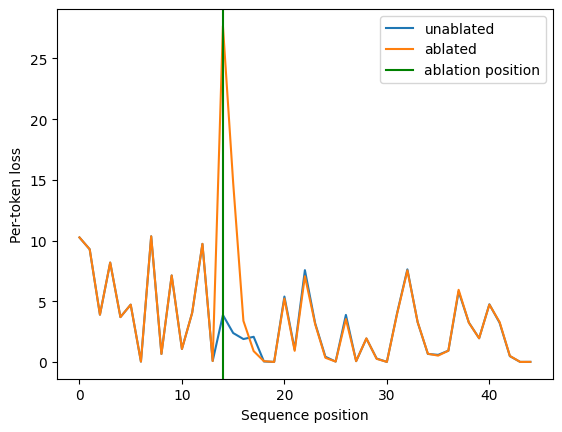

In [ ]:
plt.plot(unabl_losses[:abl_pos+30],label='unablated')
plt.plot(abl_losses[:abl_pos+30],label='ablated')
plt.axvline(x=abl_pos-1,color='green',label='ablation position')
plt.legend()
plt.ylabel('Per-token loss')
plt.xlabel('Sequence position')

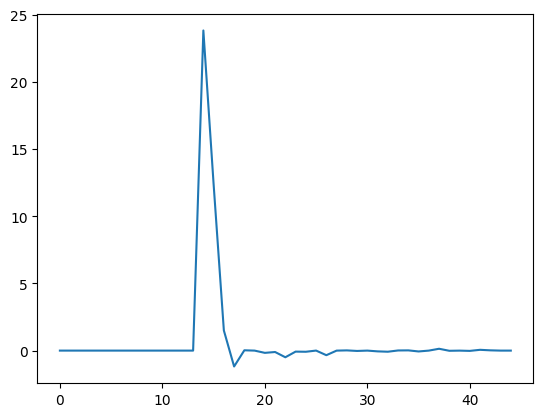

In [ ]:
plt.plot(deltas_losses[:abl_pos+30])

In [ ]:
abls_model_out = mode

In [ ]:
abl_seqs_t.unsqueeze(0).shape

torch.Size([1, 13, 600])

In [ ]:
tokenizer.decode((seq[abl_pos]))

' talks'

In [ ]:
seq_abl = torch.clone(seq)

In [ ]:
seq_abl[abl_pos] = unigram_samples[5]

In [ ]:
tokenizer.decode(seq_abl)

'Catalonia election: Puigdemont calls forALE with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests\n\nimage copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont\n\nCatalonia\'s ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.\n\nHe said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.\n\nSpain\'s Prime Minister Mariano Rajoy later appeared to reject the idea.\n\nHe said he would hold talks with the head of the new Catalan government but that leader would have to take up their post in Catalonia itself.\n\nHe avoided naming Mr Puigdemont, adding that the winner of Thursday\'s election was Inés Arrimadas, the leader of the Citizens party, which wants Catalonia to remain a semi-autonomous part of Spain.\n\nThe Citizens party is now the region\'s biggest party. although pro-

In [ ]:
candidates = torch.multinomial(torch.softmax(out_unabl.logits[0,abl_pos-1],dim=0),10) #.shape

In [ ]:
for candidate in candidates:
  print(tokenizer.decode((candidate)))

 voters
 greater
 Esp
 chemicals
 EU
 the
 abol
 a
 annex
 M


In [ ]:
torch.multinomial(unigrams_dict['pmf'], 10)

tensor([43958,  1203,    88,     9,     7,   170,   611,    36,   649,  2610])

In [ ]:
seq[int_pos]

tensor(12088)

In [ ]:
unigrams_dict['pmf']

tensor([4.6350e-02, 3.4511e-02, 3.1139e-02,  ..., 2.1577e-08, 2.1577e-08,
        2.1577e-08])

In [ ]:
torch.argwhere(unigrams_dict['sorted_unigrams'] == 12088)

tensor([[5259]])

In [ ]:
torch.argsort(unigrams_dict['sorted_unigrams']) #[12088]

tensor([191,  31,  90,  ...,  27, 181,  35])

In [ ]:
torch.argwhere(unigrams_dict['sorted_unigrams'] == 191)

tensor([], size=(0, 1), dtype=torch.int64)

# Consequents

In [ ]:
model1b = get_model('1b', 143, False)

In [ ]:
def get_logfold_inc(bigram_id, model):
  bigram = sorted_bigrams_t[bigram_id]
  unigram = bigram[1:]

  with torch.no_grad():
    ab_out = model(bigram.reshape(1,-1))
  ab_pmf = torch.softmax(ab_out.logits[0,-1],dim=-1)
  with torch.no_grad():
    b_out = model(unigram.reshape(1,-1))
  b_pmf = torch.softmax(b_out.logits[0,-1],dim=-1)

  logfold_inc = torch.log(ab_pmf) - torch.log(b_pmf)
  advantage_summands = ab_pmf * (torch.log(ab_pmf) - torch.log(b_pmf))
  advantage = advantage_summands.sum()
  return logfold_inc, advantage

In [ ]:
bigram_id = 1000

In [ ]:
lf_410, adv_410 = get_logfold_inc(bigram_id, model)
lf_1b, adv_1b = get_logfold_inc(bigram_id, model1b)

In [ ]:
adv_410, adv_1b

(tensor(1.3007), tensor(0.9058))

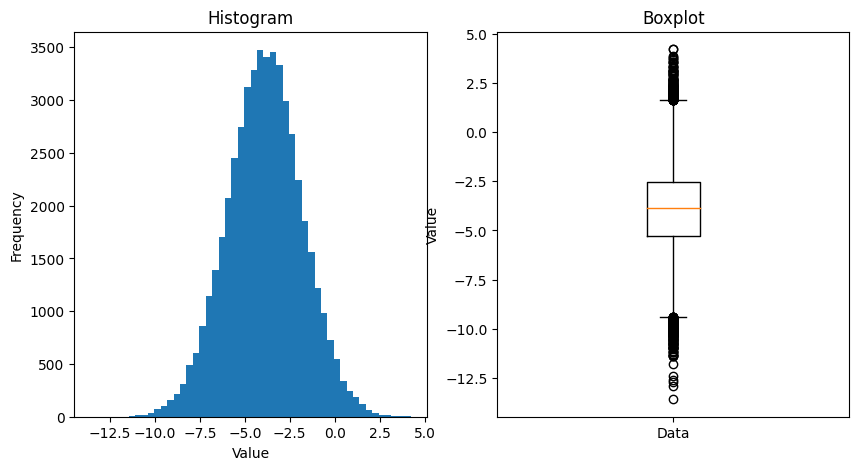

In [ ]:
hist_and_box(lf_410)

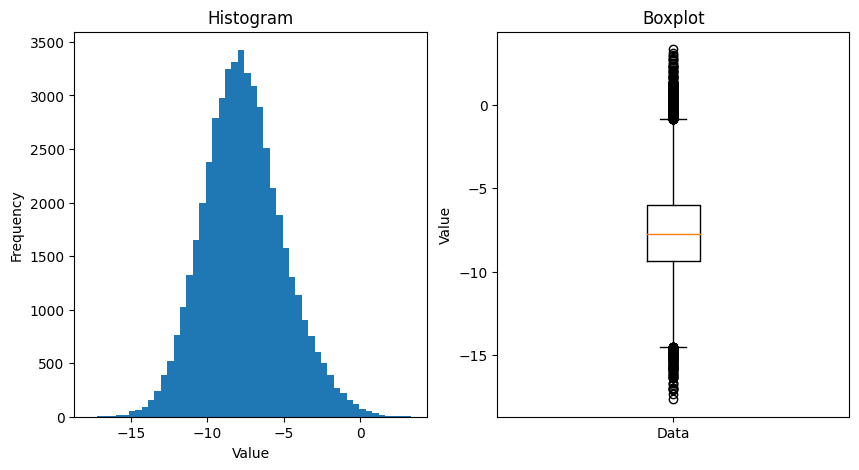

In [ ]:
hist_and_box(lf_1b)

In [ ]:
tokenizer.decode(bigram)

' prime factors'

In [ ]:
topk_410 = torch.topk(lf_410, k=10)
topk_1b = torch.topk(lf_1b, k=10)

In [ ]:
for tok, fold in zip(topk_410.indices, topk_410.values):
  print(repr(tokenizer.decode(tok)), fold.item())

'Prime' 4.227043151855469
'Word' 4.221174240112305
'Python' 3.9035263061523438
'Ring' 3.8158740997314453
'Visitor' 3.7813720703125
'Spect' 3.707582473754883
'wikipedia' 3.655050277709961
'wp' 3.5849666595458984
'jQuery' 3.5744400024414062
'Jewish' 3.557605743408203


In [ ]:
for tok, fold in zip(topk_1b.indices, topk_1b.values):
  print(repr(tokenizer.decode(tok)), fold.item())

'Notice' 3.313612937927246
'Olymp' 3.1059303283691406
'Pages' 2.9414405822753906
'Deprecated' 2.912278175354004
'iple' 2.771031379699707
'Sort' 2.7455062866210938
'What' 2.6592302322387695
'Two' 2.647122383117676
'Applied' 2.4712114334106445
'Search' 2.453441619873047


# Old

In [ ]:
torch.sort(unigram_counts,descending=True)

torch.return_types.sort(
values=tensor([2148123, 1599418, 1443164,  ...,       1,       1,       1]),
indices=tensor([  173,    13,    11,  ..., 46050,  5207, 21928]))

In [ ]:
unigram_dict = {unigram_values[i].item(): unigram_counts[i].item() for i in range(unigram_values.shape[0])}


In [ ]:
def get_unigram_prob(idx):
  return unigram_dict[idx] / unigram_counts.sum()

In [ ]:
def get_bigram_prob(idx_pair):
  idx1, idx2 = idx_pair
  return bigram_counts[(idx1, idx2)] / counts.sum()

In [ ]:
def get_bigram_ind_prob(idx_pair):
  idx1, idx2 = idx_pair
  p1, p2 = get_unigram_prob(idx1), get_unigram_prob(idx2)
  return p1 * p2

In [ ]:
def detokenize_pair(idx_pair):
  idx1, idx2 = idx_pair
  return tokenizer.decode([idx1, idx2])

In [ ]:
def mut_inf(idx_pair):
  return torch.log(get_bigram_prob(idx_pair)) - torch.log(get_bigram_ind_prob(idx_pair))

In [ ]:
for i in range(1000):
  idx_pair = sorted_bigrams[i][0]
  print(i, idx_pair, repr(detokenize_pair(idx_pair)), round(mut_inf(idx_pair).item(),2), round(get_bigram_prob(idx_pair).item(), 3))

0 (187, 187) '\n\n' 1.78 0.013
1 (15, 187) '.\n' 1.59 0.008
2 (273, 253) ' of the' 2.15 0.004
3 (275, 253) ' in the' 2.19 0.002
4 (13, 285) ', and' 1.67 0.002
5 (187, 50274) '\n    ' 2.75 0.002
6 (457, 84) '’s' 5.13 0.002
7 (13, 253) ', the' 0.55 0.002
8 (281, 253) ' to the' 1.33 0.001
9 (15, 380) '. The' 2.97 0.001
10 (27, 187) ':\n' 1.64 0.001
11 (187, 510) '\nThe' 2.77 0.001
12 (187, 50270) '\n        ' 2.83 0.001
13 (327, 253) ' on the' 2.26 0.001
14 (187, 50276) '\n  ' 2.15 0.001
15 (28, 187) ';\n' 2.22 0.001
16 (10, 187) ')\n' 1.6 0.001
17 (31, 187) '>\n' 2.5 0.001
18 (323, 253) ' for the' 1.8 0.001
19 (187, 475) '\n *' 2.54 0.001
20 (13, 533) ', but' 3.01 0.001
21 (285, 253) ' and the' 0.78 0.001
22 (32, 187) '?\n' 2.49 0.001
23 (187, 4) '\n#' 2.84 0.001
24 (281, 320) ' to be' 2.95 0.001
25 (310, 247) ' is a' 2.14 0.001
26 (94, 187) '}\n' 2.53 0.001
27 (342, 253) ' with the' 1.84 0.001
28 (551, 187) ' {\n' 2.56 0.001
29 (387, 253) ' at the' 2.31 0.001
30 (273, 247) ' of a' 1.19 

In [ ]:
tokenizer.encode('social security')

[21637, 3988]

In [ ]:
mut_inf((21637, 3988))

tensor(-inf)

# Model bigram - trigram prediction

In [ ]:
model = get_model('70m', 143, False)

In [ ]:
my_idx_pair = sorted_bigrams[6][0]
my_idx_pair

(457, 84)

In [ ]:
my_idx_pair_enc = torch.tensor([[my_idx_pair[0], my_idx_pair[1]]])

In [ ]:
#torch.softmax(model(my_idx_pair_enc).logits[0,1],dim=0)[my_idx_pair[1]]

In [ ]:
get_unigram_prob(my_idx_pair[1])

tensor(0.0033)

In [ ]:
torch.sort(model(my_idx_pair_enc).logits[0,0], descending=True)[:10]

(tensor([1577.9893, 1577.0911, 1574.5623,  ...,  226.8709,  226.8703,
          226.8698], grad_fn=<SortBackward0>),
 tensor([   84,    85,    78,  ...,  7633, 26046, 39472]))

# Trigrams

In [ ]:
def count_trigrams(T):
    trigram_counts = Counter()

    # iterate over each sequence separately
    for seq in tqdm(T):
        # Generate trigrams for current sequence
        trigrams = [(seq[i].item(), seq[i + 1].item(), seq[i + 2].item()) for i in range(len(seq) - 2)]
        # Update the trigram counts
        trigram_counts.update(trigrams)

    sorted_trigrams = sorted(trigram_counts.items(), key=lambda item: item[1], reverse=True)

    # Sort the counts in descending order and convert to a tensor
    counts = torch.tensor([count for trigram, count in trigram_counts.most_common()])

    return counts, trigram_counts, sorted_trigrams

In [ ]:
trigrams_sorted, trigram_counts, sorted_trigrams = count_trigrams(T_big[:20000])

100%|██████████| 20000/20000 [02:48<00:00, 118.81it/s]


In [ ]:
trigrams_sorted

tensor([66906, 11831,  8515,  ...,     1,     1,     1])

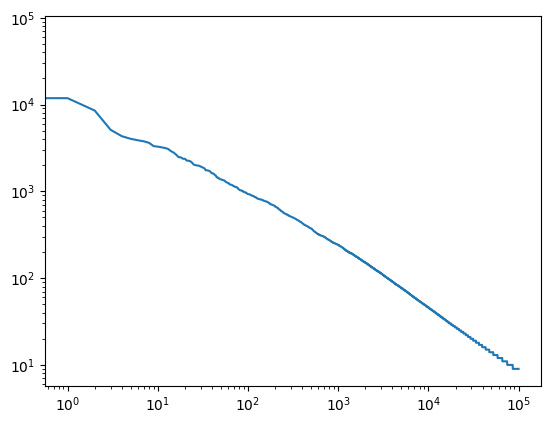

In [ ]:
plt.loglog(trigrams_sorted[:100000])

In [ ]:
trigram_triple = sorted_trigrams[0][0]

In [ ]:
def trigram_score(trigram_triple):
  denom = torch.softmax(model(torch.tensor([[trigram_triple[1]]])).logits[0,-1],dim=0)[trigram_triple[2]]
  nume = torch.softmax(model(torch.tensor([[trigram_triple[0], trigram_triple[1]]])).logits[0,-1],dim=0)[trigram_triple[2]]
  return torch.log(nume) - torch.log(denom)

In [ ]:
trigram_score(trigram_triple)

tensor(1.0254, grad_fn=<SubBackward0>)

In [ ]:
len(sorted_trigrams)

6990770

In [ ]:
trigram_scores = []
for i in range(10000):
  triple = sorted_trigrams[i][0]
  triple_score = trigram_score(triple)
  trigram_scores.append(triple_score)
  print(i, repr(tokenizer.decode(triple)), sorted_trigrams[i][1], round(triple_score.item(),2))

0 '.\n\n' 66906 1.03
1 '\n\nThe' 11831 0.0
2 ':\n\n' 8515 0.69
3 '\n\nI' 5106 -0.0
4 '\n\nA' 4311 -0.0
5 '?\n\n' 4029 0.64
6 '\n\n“' 3873 0.0
7 '\n\nIn' 3767 0.0
8 '.S.' 3616 1.36
9 ' U.S' 3315 6.01
10 '\n\n"' 3271 -0.0
11 '\n#include' 3210 1.69
12 ')\n\n' 3158 0.33
13 '.”\n\n' 3078 1.27
14 '}\n\n' 2901 0.08
15 '\n}\n' 2793 0.45
16 'Q:\n' 2639 1.68
17 ';\n    ' 2474 2.16
18 ') {\n' 2464 0.41
19 ' one of the' 2372 0.68
20 '\nWhat is' 2369 0.64
21 ', and the' 2255 0.29
22 '.com/' 2252 1.32
23 '."\n\n' 2215 1.25
24 ' it’s' 2135 0.67
25 '\n\nThis' 2035 -0.0
26 ' {\n    ' 2007 2.52
27 '\nA:' 1987 0.8
28 '\n    }' 1982 -0.21
29 'A:\n' 1961 1.28
30 '\n\n#' 1928 0.0
31 ';\nimport' 1901 0.31
32 '#include <' 1869 4.85
33 '\n\nIt' 1836 0.0
34 '!\n\n' 1747 1.16
35 '\n *\n' 1746 2.22
36 ' as well as' 1735 4.01
37 ';\n\n' 1724 -0.43
38 ' *\n *' 1691 3.76
39 ' don’t' 1643 1.57
40 '://www.' 1610 0.39
41 '\n    <' 1609 -0.34
42 '>\n    ' 1582 1.86
43 ' {\n        ' 1537 2.33
44 'What is the' 1517 2.2
4

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:4                                                                              │
│ in trigram_score:3                                                                               │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/gpt_neox/modeling_gpt_neox.py:672 in │
│ forward                                                                                          │
│                                                                                                  │
│    669 │   │   ```"""                                                                            │
│    670 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│    671 │   │                                                                                     │
│ ❱  672 │   │   outputs = self.gpt_neox(                                                          │
│    673 │   │   │   input_ids,                                                                    │
│    674 │   │   │   attention_mask=attention_mask,                                                │
│    675 │   │   │   position_ids=position_ids,                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/gpt_neox/modeling_gpt_neox.py:563 in │
│ forward                                                                                          │
│                                                                                                  │
│    560 │   │   │   │   │   head_mask[i],                                                         │
│    561 │   │   │   │   )                                   

In [ ]:
high_idx = []

In [ ]:
for i, score in enumerate(trigram_scores):
  if score > 2:
    print(i, score)
    high_idx.append(i)
  if len(high_idx) > 1000:
    break

9 tensor(6.0052, grad_fn=<SubBackward0>)
17 tensor(2.1578, grad_fn=<SubBackward0>)
26 tensor(2.5240, grad_fn=<SubBackward0>)
32 tensor(4.8452, grad_fn=<SubBackward0>)
35 tensor(2.2201, grad_fn=<SubBackward0>)
36 tensor(4.0130, grad_fn=<SubBackward0>)
38 tensor(3.7624, grad_fn=<SubBackward0>)
43 tensor(2.3349, grad_fn=<SubBackward0>)
44 tensor(2.2002, grad_fn=<SubBackward0>)
54 tensor(3.8896, grad_fn=<SubBackward0>)
55 tensor(4.6519, grad_fn=<SubBackward0>)
56 tensor(3.0546, grad_fn=<SubBackward0>)
59 tensor(3.0862, grad_fn=<SubBackward0>)
72 tensor(2.1540, grad_fn=<SubBackward0>)
73 tensor(2.4875, grad_fn=<SubBackward0>)
74 tensor(3.0973, grad_fn=<SubBackward0>)
80 tensor(3.4068, grad_fn=<SubBackward0>)
81 tensor(2.2748, grad_fn=<SubBackward0>)
84 tensor(5.7397, grad_fn=<SubBackward0>)
89 tensor(3.7200, grad_fn=<SubBackward0>)
98 tensor(5.3040, grad_fn=<SubBackward0>)
113 tensor(2.3574, grad_fn=<SubBackward0>)
121 tensor(2.1064, grad_fn=<SubBackward0>)
124 tensor(2.4904, grad_fn=<SubBa

In [ ]:
scores = torch.tensor(trigram_scores)
hist_and_box(scores)

In [ ]:
topscore_trigrams_idx = high_idx # torch.sort(scores, descending=True).indices[:300]

In [ ]:
high_triples = []

In [ ]:
for i, topscore_trigram_id in enumerate(topscore_trigrams_idx):
  triple = sorted_trigrams[topscore_trigram_id][0]
  high_triples.append(triple)
  #triple_score = trigram_score(triple)
  #trigram_scores.append(triple_score)
  print(i, topscore_trigram_id, repr(tokenizer.decode([triple[0], triple[1]])), repr(tokenizer.decode(triple))) #, sorted_trigrams[topscore_trigram_id][1], round(triple_score.item(),2))

0 9 ' U.' ' U.S'
1 17 ';\n' ';\n    '
2 26 ' {\n' ' {\n    '
3 32 '#include' '#include <'
4 35 '\n *' '\n *\n'
5 36 ' as well' ' as well as'
6 38 ' *\n' ' *\n *'
7 43 ' {\n' ' {\n        '
8 44 'What is' 'What is the'
9 54 '.h' '.h"'
10 55 '#include' '#include "'
11 56 '\n{' '\n{\n'
12 59 '>\n' '>\n<'
13 72 '\n     ' '\n     *'
14 73 ');\n' ');\n    '
15 74 '**2' '**2 +'
16 80 ' I’' ' I’m'
17 81 '{\n' '{\n    '
18 84 '\n-' "\n- '"
19 89 '**2' '**2 -'
20 98 ' and/' ' and/or'
21 113 '    {' '    {\n'
22 121 ' {\n' ' {\n  '
23 124 ' {\n' ' {\n            '
24 130 ' {\n' ' {\n\t'
25 132 ' you’' ' you’re'
26 133 '-year' '-year-'
27 146 'year-' 'year-old'
28 148 '<div' '<div class'
29 154 '\nimport' '\nimport org'
30 159 'ref-' 'ref-type'
31 160 '</div' '</div>'
32 171 '-to' '-to-'
33 175 ';\n' ';\n}'
34 176 ');\n' ');\n        '
35 180 '\nI' '\nI am'
36 182 '.2' '.2d'
37 183 '.  ' '.  The'
38 196 ';\n' ';\n\t'
39 204 '//\n' '//\n//'
40 206 '\nimport' '\nimport java'
41 208 '**3' '**3 +'
42 

In [ ]:
high_triples_t = torch.stack([torch.tensor(high_triple) for high_triple in high_triples])

In [ ]:
high_triples_t.shape

torch.Size([950, 3])

In [ ]:
torch.save(high_triples_t, '/content/drive/MyDrive/thesis/data/high_triples/950_min2.pt')

In [ ]:
sorted_trigrams[276]

((253, 4335, 2616), 290)

In [ ]:
torch.argsort(model(torch.tensor(sorted_trigrams[276][0]).reshape(1,-1)).logits[0,1], descending=True)

tensor([ 2616,  1180, 11812,  ..., 33528, 26046, 39472])

In [ ]:
torch.sort(torch.softmax(model(torch.tensor(sorted_trigrams[276][0]).reshape(1,-1)).logits[0,1],dim=0),descending=True)

torch.return_types.sort(
values=tensor([0.2223, 0.1012, 0.0577,  ..., 0.0000, 0.0000, 0.0000],
       grad_fn=<SortBackward0>),
indices=tensor([ 2616,  1180, 11812,  ..., 25766, 25835, 25878]))